In [81]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [82]:
# pip install tensorflow
!pip install opencv-python


In [83]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = 'C:/Users/bhara/python_codes/100photos'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == '59065.png':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            imh = img.astype(float)
            _img.append(img_to_array(img))

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:01<00:00, 84.70it/s]


C:\Users\bhara\AppData\Local\Temp\ipykernel_79800\3969253901.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr,sqr,i+1)


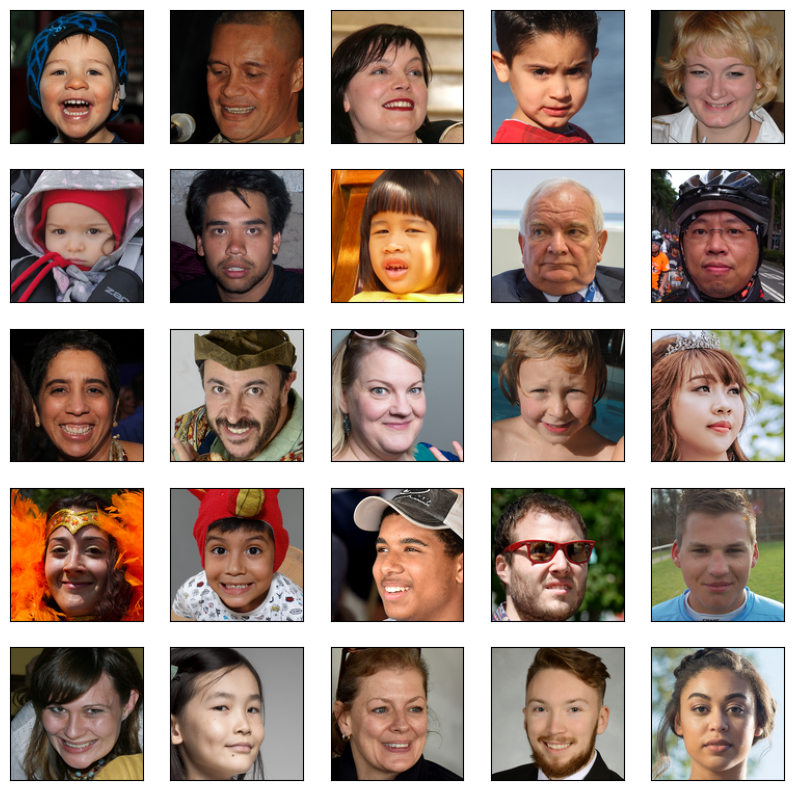

In [84]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(5)
    

In [85]:
batch_size = 16
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

In [87]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

    return model

In [88]:
generator = Generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 49152)             4915200   
                                                                 
 reshape_1 (Reshape)         (None, 128, 128, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 128)     6144      
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization_9 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                      

In [89]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model
  

In [90]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization_14 (Ba  (None, 64, 64, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_15 (Ba  (None, 32, 32, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 32, 128)      

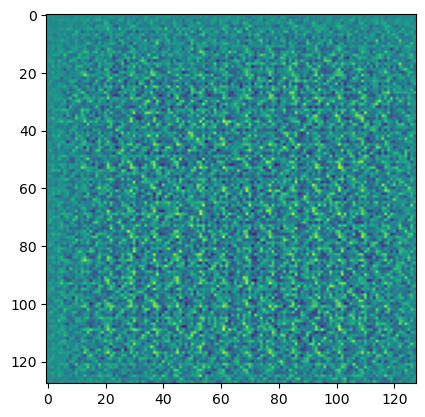

In [94]:
noise = np.random.normal(0,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [95]:
optimizer = tf.keras.optimizers.legacy.RMSprop(
    lr=0.0001,
    clipvalue=1.0,
    decay=1e-8
)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [96]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

In [97]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [110]:
def plot_generated_images(square = 5, epochs = 30):
    
    
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

In [99]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))
       

In [100]:
train(30,dataset)


Epoch : 1
 Time:95.0
Generator Loss: 0.004514915402978659 Discriminator Loss: 5.742416858673096

Epoch : 2
 Time:89.0
Generator Loss: 0.7645804286003113 Discriminator Loss: 0.923773467540741

Epoch : 3
 Time:91.0
Generator Loss: 0.602310061454773 Discriminator Loss: 0.9929013252258301

Epoch : 4
 Time:89.0
Generator Loss: 0.6146427392959595 Discriminator Loss: 1.0684278011322021

Epoch : 5
 Time:90.0
Generator Loss: 1.7768657207489014 Discriminator Loss: 0.4188183546066284

Epoch : 6
 Time:90.0
Generator Loss: 1.0728123188018799 Discriminator Loss: 0.5101372003555298

Epoch : 7
 Time:92.0
Generator Loss: 0.9951940774917603 Discriminator Loss: 0.6078754663467407

Epoch : 8
 Time:92.0
Generator Loss: 2.7162532806396484 Discriminator Loss: 0.09403969347476959

Epoch : 9
 Time:90.0
Generator Loss: 5.753006935119629 Discriminator Loss: 0.2769598960876465

Epoch : 10
 Time:90.0
Generator Loss: 3.328672409057617 Discriminator Loss: 0.16607679426670074

Epoch : 11
 Time:88.0
Generator Loss: 0

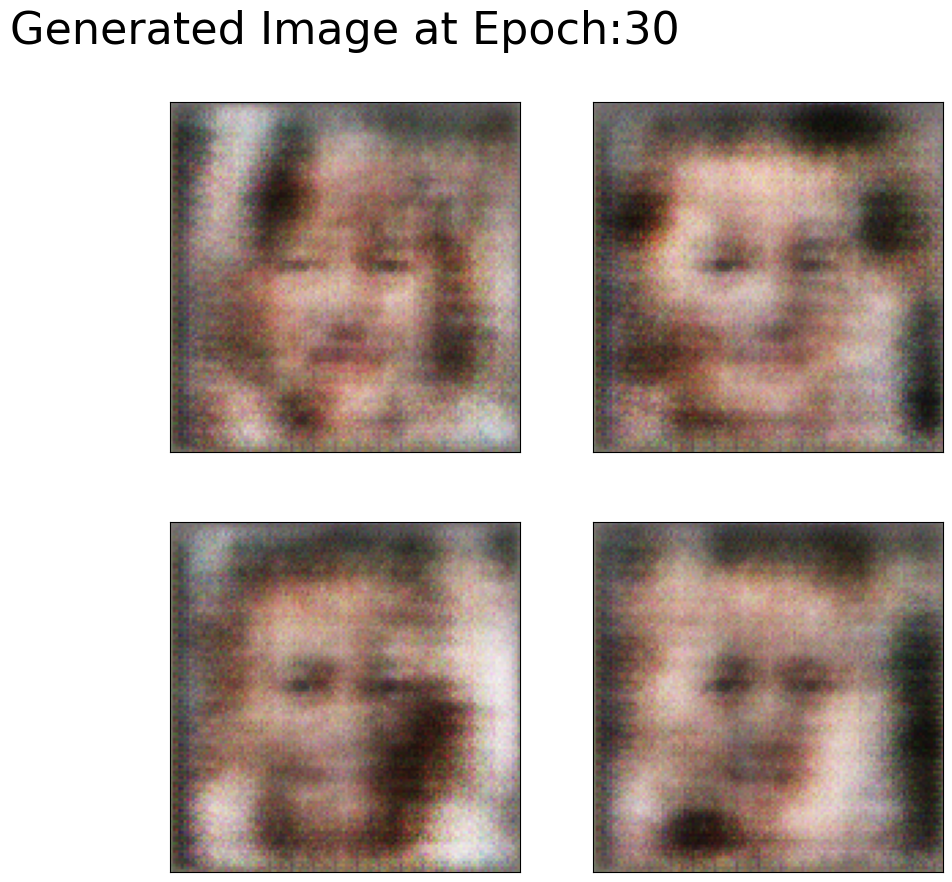

In [111]:
plot_generated_images(2)

In [102]:
generator.save('generator.h5')
discriminator.save("discriminator.h5")